<div align="center"> 
    <hr>
  <font size="6"><b>Dev | Dirty Entity Resolution Notebook</b> </font>
   <hr>
</div>

In [1]:
import os
import sys
import pandas as pd
import networkx
from networkx import (
    draw,
    DiGraph,
    Graph,
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation
from pyjedai.datamodel import Data

d1 = pd.read_csv("../data/der/cora/cora.csv", sep='|')
gt = pd.read_csv("../data/der/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

[nltk_data] Downloading package stopwords to /home/jm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Block Building

In [2]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

/home/conda/miniconda3/envs/pyjedai-progressive/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
blocks = StandardBlocking().build_blocks(data)

Standard Blocking: 100%|██████████| 1295/1295 [00:00<00:00, 60953.46it/s]


#### EmbeddingsNNBlockBuilding

In [4]:
from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding

emb = EmbeddingsNNBlockBuilding(
    vectorizer='bert',
    similarity_search='faiss'
)
blocks = emb.build_blocks(data)

Building blocks via Embeddings-NN Block Building [bert, faiss]


Embeddings-NN Block Building [bert, faiss]:   0%|          | 0/1295 [00:00<?, ?it/s]

Device selected:  cuda


Embeddings-NN Block Building [bert, faiss]: 100%|██████████| 1295/1295 [00:17<00:00, 74.26it/s]


Vector size:  (1295, 768)
Saving embeddings...
Saving file:  .embeddings/bert_d1.npy
Saving file:  .embeddings/bert_d2.npy


In [5]:
emb.evaluate(blocks)

***************************************************************************************************************************
                                         Μethod:  Embeddings-NN Block Building
***************************************************************************************************************************
Method name: Embeddings-NN Block Building
Parameters: 
	Vectorizer: bert
	Similarity-Search: faiss
	Top-K: 30
	Vector size: 768
Runtime: 17.4398 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     23.30% 
	Recall:        72.15%
	F1-score:      35.22%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 23.298070238072867,
 'Recall %': 72.15432960893855,
 'F1 %': 35.2229308410153,
 'True Positives': 12399,
 'False Positives': 40820,
 'True Negatives': 815896.0,
 'False Negatives': 4785}

### Entity Matching

In [6]:
from pyjedai.matching import EntityMatching

In [7]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

# pairs_graph = EM.predict(blocks, data)

In [8]:
pairs_graph = EM.predict(blocks, data)

Entity Matching (jaccard, white_space_tokenizer): 100%|██████████| 1295/1295 [00:03<00:00, 427.40it/s]


In [9]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5,
    # embedings=None, # gensim
    attributes=attr,
    qgram=2 # for ngram metric or jaccard
)

pairs_graph = EM.predict(blocks, data)

Entity Matching (jaccard, white_space_tokenizer): 100%|██████████| 1295/1295 [00:05<00:00, 230.54it/s]


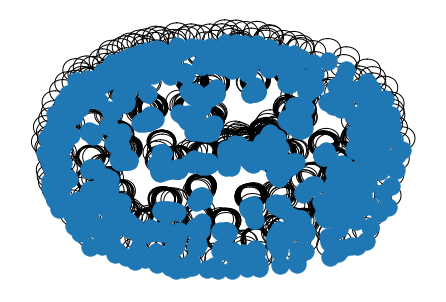

In [10]:
draw(pairs_graph)

In [11]:
EM.evaluate(pairs_graph)

***************************************************************************************************************************
                                         Μethod:  Entity Matching
***************************************************************************************************************************
Method name: Entity Matching
Parameters: 
	Metric: jaccard
	Attributes: {'author': 0.6, 'title': 0.4}
	Similarity threshold: 0.5
	Tokenizer: white_space_tokenizer
	Vectorizer: None
	Qgrams: 2
Runtime: 5.6179 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     78.14% 
	Recall:        29.11%
	F1-score:      42.42%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 78.13524910198345,
 'Recall %': 29.11429236499069,
 'F1 %': 42.421672955441565,
 'True Positives': 5003,
 'False Positives': 1400,
 'True Negatives': 808500.0,
 'False Negatives': 12181}

### Entity Clustering

In [12]:
from pyjedai.clustering import ConnectedComponentsClustering, UniqueMappingClustering

In [13]:
UMC = ConnectedComponentsClustering()
clusters = UMC.process(pairs_graph, data)

In [14]:
CCC = ConnectedComponentsClustering()
clusters = CCC.process(pairs_graph, data)

In [15]:
CCC.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0082 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     84.84% 
	Recall:        64.14%
	F1-score:      73.05%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 84.8356554537757,
 'Recall %': 64.13524208566108,
 'F1 %': 73.04722452361226,
 'True Positives': 11021,
 'False Positives': 1970.0,
 'True Negatives': 814518.0,
 'False Negatives': 6163}

# WorkFlow 2

### Similarity Joins

In [17]:
from pyjedai.joins import EJoin, TopKJoin

In [19]:
SAEJ = EJoin(
    similarity_threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
)
g = SAEJ.fit(data)

EJoin (jaccard): 100%|██████████| 2590/2590 [00:09<00:00, 265.54it/s]  


In [20]:
SAEJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  EJoin
***************************************************************************************************************************
Method name: EJoin
Parameters: 
	similarity_threshold: 0.5
	metric: jaccard
	tokenization: qgrams_multiset
	qgrams: 2
Runtime: 9.8024 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     65.80% 
	Recall:        93.03%
	F1-score:      77.08%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 15987
	False positives: 8311
	True negatives: 819484
	False negatives: 1197
	Total comparisons: 24298
─────────────────────────────────────────────────────────────────────────────────

{'Precision %': 65.79553872746729,
 'Recall %': 93.03421787709497,
 'F1 %': 77.07921508124006,
 'True Positives': 15987,
 'False Positives': 8311,
 'True Negatives': 819484.0,
 'False Negatives': 1197}

In [21]:
TSAJ = TopKJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
)
g = TSAJ.fit(data)

Top-K Join (jaccard): 100%|██████████| 2590/2590 [00:07<00:00, 339.90it/s]  


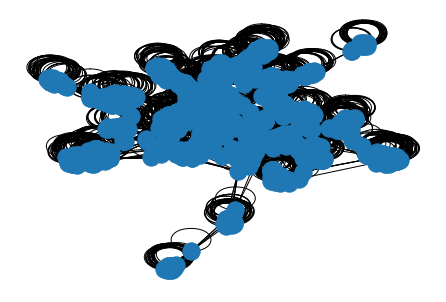

In [22]:
draw(g)

In [23]:
TSAJ.evaluate(g, with_classification_report=True)

***************************************************************************************************************************
                                         Μethod:  Top-K Join
***************************************************************************************************************************
Method name: Top-K Join
Parameters: 
	similarity_threshold: 0.25547445255474455
	K: 20
	metric: jaccard
	tokenization: qgrams
	qgrams: 3
Runtime: 7.6401 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:     58.34% 
	Recall:        63.75%
	F1-score:      60.92%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Classification report:
	True positives: 10954
	False positives: 7822
	True negatives: 814451
	False negatives: 6230
	Total comparisons: 18776
─────────────────────────────────────────────────────────

{'Precision %': 58.340434597358325,
 'Recall %': 63.74534450651769,
 'F1 %': 60.923248053392655,
 'True Positives': 10954,
 'False Positives': 7822,
 'True Negatives': 814451.0,
 'False Negatives': 6230}

### Entity Clustering

In [24]:
from pyjedai.clustering import ConnectedComponentsClustering

In [25]:
CCC = ConnectedComponentsClustering()
clusters = CCC.process(g, data)

In [26]:
CCC.evaluate(clusters)

***************************************************************************************************************************
                                         Μethod:  Connected Components Clustering
***************************************************************************************************************************
Method name: Connected Components Clustering
Parameters: 
Runtime: 0.0196 seconds
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance:
	Precision:      2.05% 
	Recall:       100.00%
	F1-score:       4.02%
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


{'Precision %': 2.050927058655034,
 'Recall %': 100.0,
 'F1 %': 4.019418770152353,
 'True Positives': 17184,
 'False Positives': 820681.0,
 'True Negatives': 820681.0,
 'False Negatives': 0}